# OU N-layer-Synthetic drifter trajectories exponentially autocorrelated velocities

We generate synthetic exponentially autocorrelated velocity timeseries.
A modification leading to differentiable solutions is used and consists in (multi-layer) embeded Ornstein–Uhlenbeck (OU) processes [Sawford 1991, Viggiano et al. 2020].
All processes are assumed Gaussian and could be extended to more general distributions [Viggiano et al. 2020].
- use synthetic exponentially autocorrelated velocity timeseries generated by zarr_synthetic_trajectories with n=10.
- Fit to theoritical PSD and autocorrelation functions
- verify the Parseval's theorem
References:

- B. Viggiano, J. Friedrich, R. Volk, M. Bourgoin, R. B. Cal, and L. Chevillard. Modelling lagrangian velocity and acceleration in turbulent flows as infinitely differentiable stochastic processes. Journal of Fluid Mechanics, 900, 2020.
- B. Sawford. Reynolds number effects in lagrangian stochastic models of turbulent dispersion. Physics of Fluids A: Fluid Dynamics, 3(6):1577–1586, 1991.


---

# N-layers Embedded OU processes: Viggiano et al. 2020 

We generate timeseries corresponding to their equations (2.14-2.18).

- Theoritical behaviour of PSD, autocorrrelation
- Generated times series VS theorical functions fit
- Parseval verification

In [1]:
import os
import xarray as xr
import numpy as np
from scipy.special import erfc, erf


import matplotlib.pyplot as plt
from cycler import cycler

import viggiano_2020 as vig
import plot as fplt
from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

from GDP_lib import root_dir

root_dir = "/home1/datawork/mdemol/GDP/synthetics_trajectories"

ModuleNotFoundError: No module named 'viggiano_2020'

In [2]:
path = os.path.join(root_dir, "synthetic_traj_ou_taueta.zarr")
ds = xr.open_zarr(path, decode_timedelta=False)  # tau_eta=1
ds

<xarray.Dataset>
Dimensions:    (T: 4, tau_eta: 5, draw: 10, freq_time: 2400, time: 24000,
                lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * tau_eta    (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables:
    Ea         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    Eu         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    Ex         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    a          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 5, 5000, 10), meta=np.ndarray>
    aa         (T, tau_eta, draw, lags) float64 dask.array<chunksize=(4, 5, 10, 5000), meta=np.ndarray>
    u          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 5, 5000, 10), meta=np.ndarray>
    uu         (T, tau_eta, draw, lags) float64 dask.array<chunksize=(4, 5, 10, 5000), meta=np.ndarray>
    x          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 5, 5000, 10), meta=np.ndarray>
    xx         (T, tau_eta, draw, lags) float64 dask.array<chunksize=(4, 5, 10, 5000), meta=np.ndarray>
Attributes:
    description:   synthetic trajectories simulated via the embedded OU proce...
    n_layers:      5
    sigma_u:       1
    tau_eta_days:  [0.020833333333333332, 0.041666666666666664, 0.08333333333...

In [3]:
colors = get_cmap_colors(max(ds.T.size, ds.tau_eta.size), cmap="plasma")
plt.rc("axes", prop_cycle=cycler(color=colors))

________
## Verify viggiano bib :  CV pour n=1 -> OK

In [4]:
a = vig.PSDu_1_ds(ds)
b = vig.PSDu_n(ds.freq_time * 2 * np.pi, ds.attrs["sigma_u"], ds.T, ds["tau_eta"], n=1)

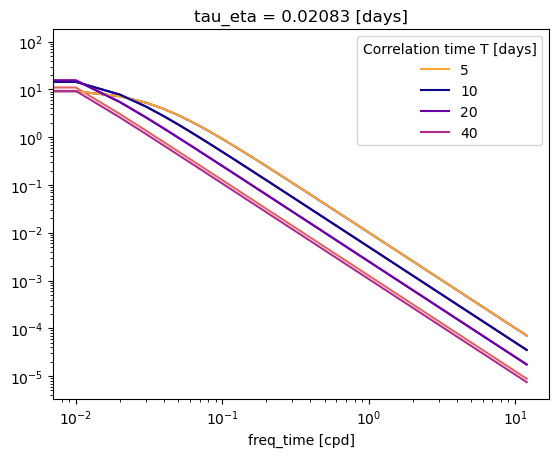

In [5]:
a.plot(hue="T")
b.isel(tau_eta=0).plot(hue="T")
plt.xscale("log")
plt.yscale("log")

________________
## Theoritical behaviour of PSD, autocorrrelation

In [6]:
def add_theoritical_func(ds):
    ds["PSDu"] = vig.PSDu_n_ds(ds)
    ds["PSDa"] = vig.PSDa_n_ds(ds)
    ds["PSDu_exp"] = vig.PSDu_1_ds(ds)
    ds["PSDa_exp"] = vig.PSDa_1_ds(ds)
    ds["coru_inf"] = vig.Coru_inf_ds(ds)
    ds["cora_inf"] = vig.Cora_inf_ds(ds)


add_theoritical_func(ds)
ds

<xarray.Dataset>
Dimensions:    (T: 4, tau_eta: 5, draw: 10, freq_time: 2400, time: 24000,
                lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * tau_eta    (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables: (12/15)
    Ea         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    Eu         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    Ex         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    a          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 5, 5000, 10), meta=np.ndarray>
    aa         (T, tau_eta, draw, lags) float64 dask.array<chunksize=(4, 5, 10, 5000), meta=np.ndarray>
    u          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 5, 5000, 10), meta=np.ndarray>
    ...         ...
    PSDu       (T, tau_eta, freq_time) float64 4.912e-07 4.944e-07 ... 3.069e-23
    PSDa       (T, tau_eta, freq_time) float64 3.741e-13 3.759e-13 ... 2.333e-29
    PSDu_exp   (T, freq_time) float64 7.036e-05 7.048e-05 ... 8.825e-06 8.81e-06
    PSDa_exp   (T, freq_time) float64 5.358e-11 5.358e-11 ... 6.698e-12
    coru_inf   (lags, T, tau_eta) float64 1.0 1.0 1.0 ... 1.431e-11 1.473e-11
    cora_inf   (T, tau_eta, lags) float64 7.236e-10 2.628e-10 ... -1.234e-24
Attributes:
    description:   synthetic trajectories simulated via the embedded OU proce...
    n_layers:      5
    sigma_u:       1
    tau_eta_days:  [0.020833333333333332, 0.041666666666666664, 0.08333333333...

### Dependance on tau_eta
CV to the PSD for n=1 when $\tau_{\eta} \rightarrow 0$ ?

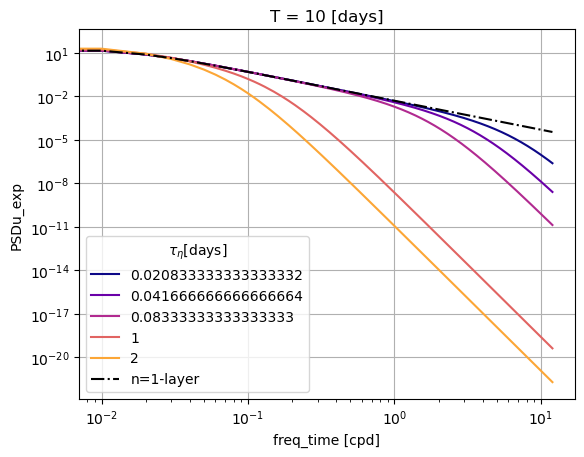

In [7]:
ds.PSDu.isel(T=1).plot(hue="tau_eta", label=ds.attrs["tau_eta_days"])
ds.PSDu_exp.isel(T=1).plot(color="k", ls="-.", label="n=1-layer")

plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(title=r"$\tau_{\eta}$[days]")

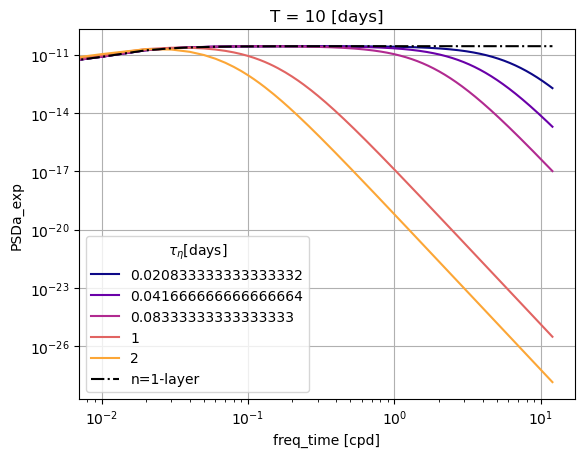

In [8]:
ds.PSDa.isel(T=1).plot(hue="tau_eta", label=ds.attrs["tau_eta_days"])
ds.PSDa_exp.isel(T=1).plot(color="k", ls="-.", label="n=1-layer")

plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(title=r"$\tau_{\eta}$[days]")

### Dependance on T

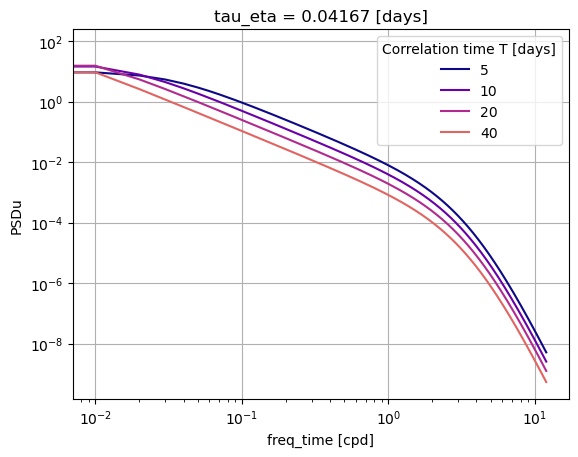

In [9]:
ds.PSDu.isel(tau_eta=1).plot(hue="T")
plt.grid()
plt.xscale("log")
plt.yscale("log")

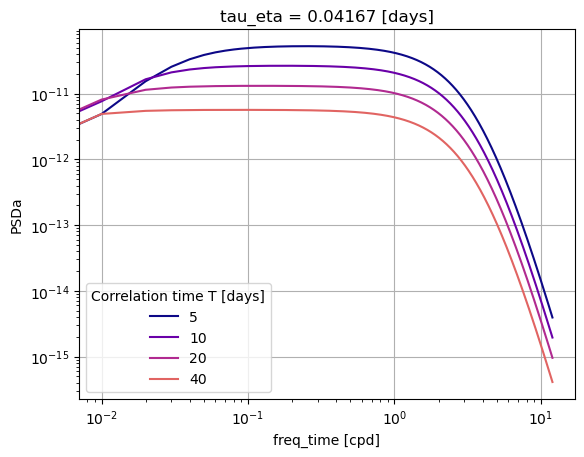

In [10]:
ds.PSDa.isel(tau_eta=1).plot(hue="T")
plt.grid()
plt.xscale("log")
plt.yscale("log")

### Mixed dependence

Text(0.5, 1.0, '')

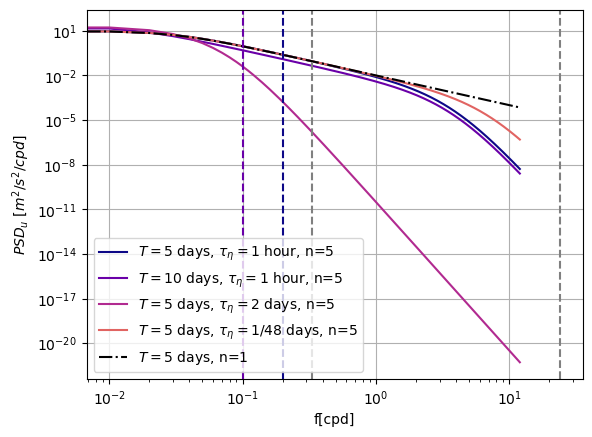

In [11]:
ds.PSDu.sel(T=5, tau_eta=1 / 24).plot(
    color=colors[0], label=r"$T=5$ days, $\tau_{\eta}=1$ hour, n=5"
)
ds.PSDu.sel(T=10, tau_eta=1 / 24).plot(
    color=colors[1], label=r"$T=10$ days, $\tau_{\eta}=1$ hour, n=5"
)
ds.PSDu.sel(T=5, tau_eta=2).plot(
    color=colors[2], label=r"$T=5$ days, $\tau_{\eta}=2$ days, n=5"
)
ds.PSDu.sel(T=5, tau_eta=1 / 48).plot(
    color=colors[3], label=r"$T=5$ days, $\tau_{\eta}=1/48$ days, n=5"
)
ds.PSDu_exp.sel(T=5).plot(color="k", ls="-.", label=r"$T=5$ days, n=1")

plt.axvline(1 / 5, ls="--", color=colors[0])
plt.axvline(1 / 10, ls="--", color=colors[1])
plt.axvline(24, ls="--", color="grey")
plt.axvline(1 / 3, ls="--", color="grey")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("f[cpd]")
plt.ylabel(r"$PSD_u$ $[m^2/s^2/cpd]$")
plt.grid()
plt.legend()
plt.title("")

Text(0.5, 1.0, '')

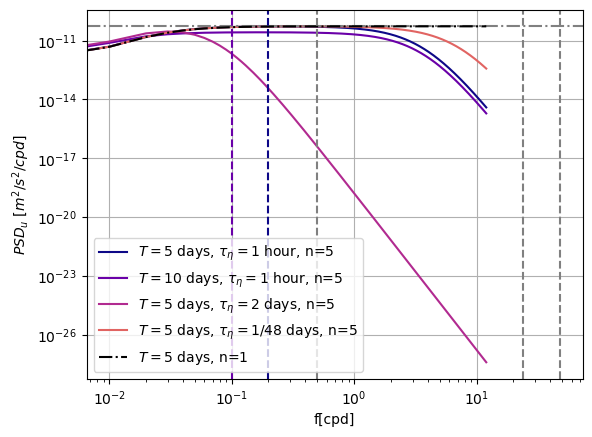

In [12]:
ds.PSDa.sel(T=5, tau_eta=1 / 24).plot(
    color=colors[0], label=r"$T=5$ days, $\tau_{\eta}=1$ hour, n=5"
)
ds.PSDa.sel(T=10, tau_eta=1 / 24).plot(
    color=colors[1], label=r"$T=10$ days, $\tau_{\eta}=1$ hour, n=5"
)
ds.PSDa.sel(T=5, tau_eta=2).plot(
    color=colors[2], label=r"$T=5$ days, $\tau_{\eta}=2$ days, n=5"
)
ds.PSDa.sel(T=5, tau_eta=1 / 48).plot(
    color=colors[3], label=r"$T=5$ days, $\tau_{\eta}=1/48$ days, n=5"
)
plt.axhline(2 / 5 / (86400**2), ls="-.", color="grey")
ds.PSDa_exp.sel(T=5).plot(color="k", ls="-.", label=r"$T=5$ days, n=1")

plt.axvline(1 / 5, ls="--", color=colors[0])
plt.axvline(1 / 10, ls="--", color=colors[1])
plt.axvline(24, ls="--", color="grey")
plt.axvline(1 / 2, ls="--", color="grey")
plt.axvline(48, ls="--", color="grey")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("f[cpd]")
plt.ylabel(r"$PSD_u$ $[m^2/s^2/cpd]$")
plt.grid()
plt.legend()
plt.title("")

________
# Generated times series VS theorical functions

In [13]:
ds

<xarray.Dataset>
Dimensions:    (T: 4, tau_eta: 5, draw: 10, freq_time: 2400, time: 24000,
                lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * tau_eta    (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables: (12/15)
    Ea         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    Eu         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    Ex         (T, tau_eta, draw, freq_time) float64 dask.array<chunksize=(4, 5, 10, 2400), meta=np.ndarray>
    a          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 5, 5000, 10), meta=np.ndarray>
    aa         (T, tau_eta, draw, lags) float64 dask.array<chunksize=(4, 5, 10, 5000), meta=np.ndarray>
    u          (T, tau_eta, time, draw) float64 dask.array<chunksize=(4, 5, 5000, 10), meta=np.ndarray>
    ...         ...
    PSDu       (T, tau_eta, freq_time) float64 4.912e-07 4.944e-07 ... 3.069e-23
    PSDa       (T, tau_eta, freq_time) float64 3.741e-13 3.759e-13 ... 2.333e-29
    PSDu_exp   (T, freq_time) float64 7.036e-05 7.048e-05 ... 8.825e-06 8.81e-06
    PSDa_exp   (T, freq_time) float64 5.358e-11 5.358e-11 ... 6.698e-12
    coru_inf   (lags, T, tau_eta) float64 1.0 1.0 1.0 ... 1.431e-11 1.473e-11
    cora_inf   (T, tau_eta, lags) float64 7.236e-10 2.628e-10 ... -1.234e-24
Attributes:
    description:   synthetic trajectories simulated via the embedded OU proce...
    n_layers:      5
    sigma_u:       1
    tau_eta_days:  [0.020833333333333332, 0.041666666666666664, 0.08333333333...

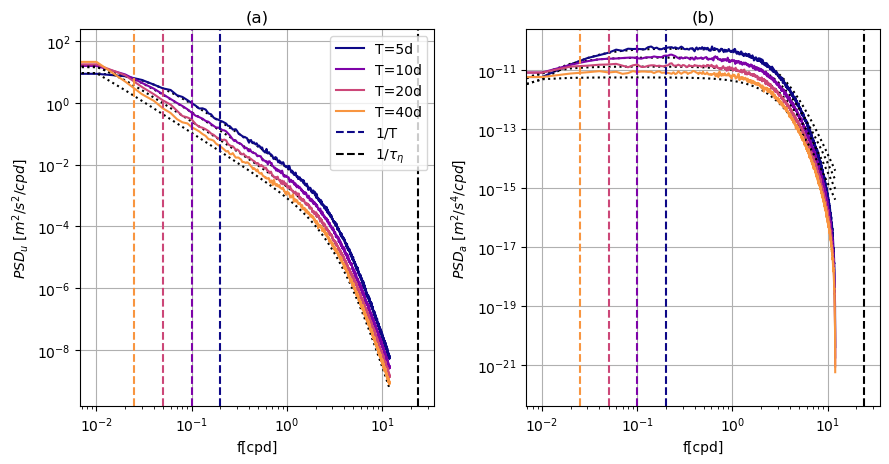

In [14]:
fplt.plot_psd(ds.sel(tau_eta=1 / 24));

In [16]:
ds.cora_inf.isel(T=0, tau_eta=1)

<xarray.DataArray 'cora_inf' (lags: 24000)>
array([ 3.60835969e-10,  2.79846093e-10,  1.29400075e-10, ...,
       -7.67531934e-99, -7.61162411e-99, -7.54845747e-99])
Coordinates:
    T        int64 5
  * lags     (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
    tau_eta  float64 0.04167

In [17]:
ds.aa.isel(T=0, tau_eta=1).mean("draw").compute()

<xarray.DataArray 'aa' (lags: 24000)>
array([1.97998184e-10, 1.82278790e-10, 1.43533264e-10, ...,
       1.89424445e-14, 1.64361027e-14, 9.52719018e-15])
Coordinates:
    T        int64 5
  * lags     (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
    tau_eta  float64 0.04167

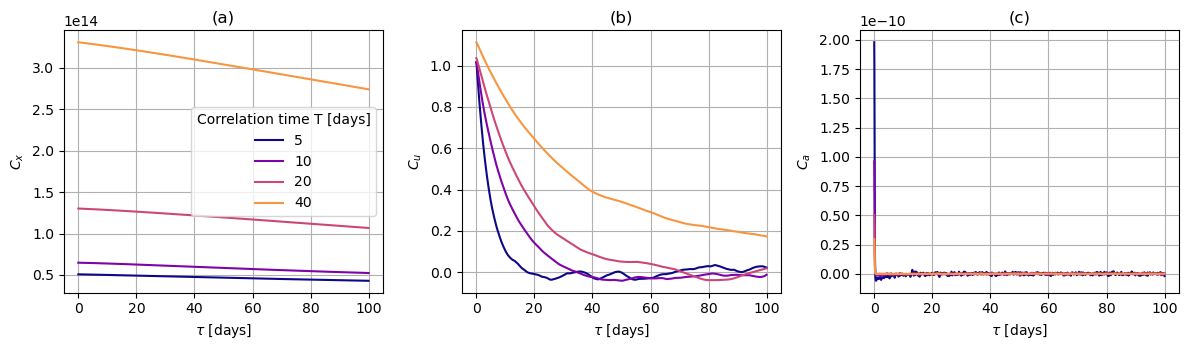

In [14]:
fplt.plot_autocorrelations(
    ds.sel(tau_eta=1 / 24).mean("draw").drop(["coru_inf", "cora_inf"]), tau_max=100
);

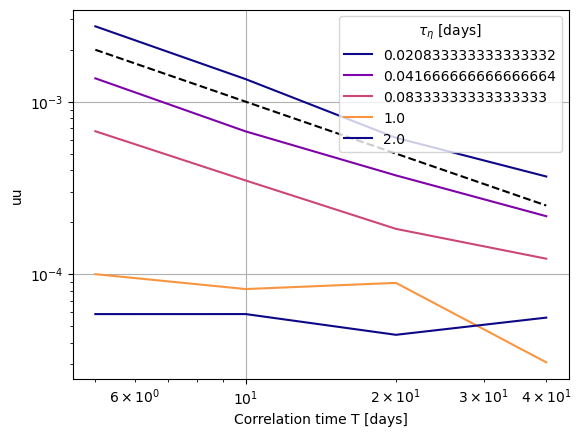

In [19]:
(1 - ds["uu"].sel(lags=1 / 24) / ds["uu"].sel(lags=0)).mean("draw").plot(hue="tau_eta")
plt.plot(ds.T, 1 / ds.T * 1e-2, color="k", ls="--")  # pente=-1
plt.xscale("log")
plt.yscale("log")
plt.grid()

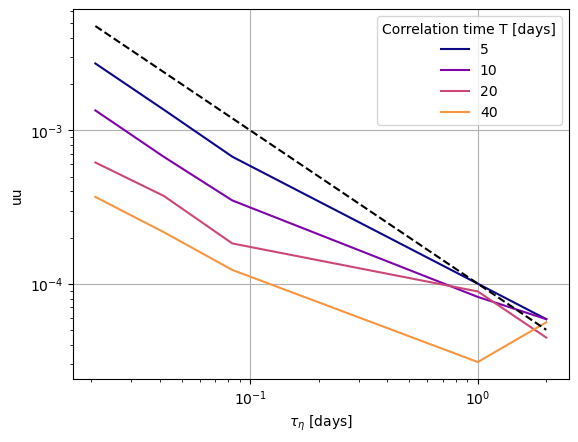

In [20]:
(1 - ds["uu"].sel(lags=1 / 24) / ds["uu"].sel(lags=0)).mean("draw").plot(hue="T")
plt.plot(ds.tau_eta, 1 / ds.tau_eta * 1e-4, color="k", ls="--")  # pente=-1
plt.xscale("log")
plt.yscale("log")
plt.grid()

________
## Verify Parseval -> Parseval ok

In [30]:
(ds.u**2).mean(["time", "draw"]).compute()

<xarray.DataArray 'u' (T: 4, tau_eta: 5)>
array([[1.01215042, 1.01419973, 1.00208061, 1.01189939, 1.00606162],
       [1.02296991, 1.01833188, 1.02206582, 1.02164723, 1.02540996],
       [1.02077319, 1.03644009, 1.02724438, 1.09514448, 1.03277233],
       [1.06924104, 1.11345639, 1.03991843, 1.10007706, 1.04382942]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * tau_eta  (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0

In [32]:
ds.u.var("time").mean("draw").compute()

<xarray.DataArray 'u' (T: 4, tau_eta: 5)>
array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * tau_eta  (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0

In [ ]:
ds.Eu.integrate("freq_time").mean("draw").compute()

<xarray.DataArray 'Eu' (T: 4, tau_eta: 5)>
array([[1.02784397, 1.00576381, 1.00481922, 1.01945815, 1.00198009],
       [0.98233314, 1.02953734, 1.03614619, 1.01440837, 1.01597892],
       [1.04412241, 1.01487845, 1.0328713 , 1.08482969, 1.02724444],
       [1.09711302, 1.12576868, 1.02365808, 1.11222639, 1.06434936]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * tau_eta  (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0

In [35]:
ds.PSDu.integrate("freq_time").compute()

<xarray.DataArray 'PSDu' (T: 4, tau_eta: 5)>
array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * tau_eta  (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0

In [36]:
(ds.a**2).mean(["time", "draw"]).compute()

<xarray.DataArray 'a' (T: 4, tau_eta: 5)>
array([[3.62778808e-10, 1.97998184e-10, 1.00542793e-10, 7.08734628e-12,
        2.80938148e-12],
       [1.74039558e-10, 9.60610717e-11, 5.07624066e-11, 3.68234371e-12,
        1.96598109e-12],
       [8.07912577e-11, 5.04372380e-11, 2.49663784e-11, 2.39677601e-12,
        1.04940886e-12],
       [4.65480545e-11, 2.96770525e-11, 1.19948649e-11, 1.18109934e-12,
        6.07800044e-13]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * tau_eta  (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0

In [37]:
ds.Ea.integrate("freq_time").mean("draw").compute()

<xarray.DataArray 'Ea' (T: 4, tau_eta: 5)>
array([[3.61642111e-10, 1.97320845e-10, 1.00329643e-10, 7.18144542e-12,
        2.85708816e-12],
       [1.73982364e-10, 9.59040378e-11, 5.07993116e-11, 3.65327312e-12,
        1.95611677e-12],
       [8.06198559e-11, 5.07366231e-11, 2.49884569e-11, 2.40187147e-12,
        1.06106901e-12],
       [4.64991109e-11, 2.96960861e-11, 1.19701504e-11, 1.19340128e-12,
        6.01030951e-13]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * tau_eta  (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0

In [38]:
ds.PSDa.integrate("freq_time").compute()

<xarray.DataArray 'PSDa' (T: 4, tau_eta: 5)>
array([[3.98455553e-10, 1.99239632e-10, 9.87955939e-11, 6.91096876e-12,
        2.90991030e-12],
       [1.99635003e-10, 1.00030362e-10, 4.98088002e-11, 3.79275358e-12,
        1.72726172e-12],
       [9.85881275e-11, 4.94467981e-11, 2.46693475e-11, 1.95624521e-12,
        9.26492409e-13],
       [4.23884868e-11, 2.12625555e-11, 1.06107442e-11, 8.44886450e-13,
        4.00561908e-13]])
Coordinates:
  * T        (T) int64 5 10 20 40
  * tau_eta  (tau_eta) float64 0.02083 0.04167 0.08333 1.0 2.0